#### Print your name

In [1]:
## Your code here 
print("Exercise by: Janne Bragge")

Exercise by: Janne Bragge


# Compare fully connected network vs. convolution network performance

In this notebook, you'll compare 3 different neural network with same parameter count. First we start with fully connected network (FC), then we try convolutinal network (CNN) and finally we try pretrained densenet (also CNN).

We try to make all networks with same parameter count (= 7...8M parameters). Target size you can find from densenet description below. 

<img src='../data/assets/densenet121.png' width=600>

https://pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html

**Note.** Running 6 epochs with all these 3 networks takes some time, about 25 min / network. 


In [2]:
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

print(torch.cuda.is_available())
print(torch.__version__)

if torch.cuda.is_available() :
    device = "cuda" 
else : 
    device = "cpu" 

print("Device =", device)

True
2.4.1+cu121
Device = cuda


In [3]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [4]:
BATCH_SIZE = 256
EPOCHS = 6

***
### Exercise - Data loaders:
Define needed transforms for training images and testing images.

**Use parameters:**
- mini-batch size = BATCH_SIZE
- Use normalization: means `[0.485, 0.456, 0.406]` and the stds `[0.229, 0.224, 0.225]`
- image size: 224x224 pixels

In [5]:
## Task 1:
## Your code here 

# Asetetaan parametrit
IMAGE_SIZE =  224 # Kuvan koko 224x224

# Määritellään tarvittavat transformaatiot
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Skaalaa kuva oikeaan kokoon
    transforms.ToTensor(),  # Muuntaa kuvan tensoriksi
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisointi
])

# Ladataan data
train_dataset = datasets.ImageFolder("/home/jovyan/shared/Cat_Dog_data/train", transform=transform)
test_dataset = datasets.ImageFolder("/home/jovyan/shared/Cat_Dog_data/test", transform=transform)

# Luodaan DataLoaderit
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

 

***
### Exercise - Train function:
Define train function to train the model.

```python
def train_model(model, device, epochs) :

```

In [6]:
## Task 2:
## Your code here 
import time


def train_model(model, device, epochs, 
                train_loader=train_loader, 
                test_loader=test_loader, 
                #criterion=nn.BCEWithLogitsLoss(),
                criterion=nn.CrossEntropyLoss(), 
                optimizer_fn=lambda model: optim.Adam(model.parameters(), lr=0.001)):

    model.to(device)  # Siirretään malli oikealle laitteelle (CPU/GPU)
    
    optimizer = optimizer_fn(model)  # Luodaan optimointialgoritmi

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    start_time = time.time()  # Aloitetaan ajanotto
    
    for epoch in range(epochs):  
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:  
            images, labels = images.to(device), labels.to(device)  
            images = images.view(images.size(0), -1)  # 🔥 Tasoitetaan kuvat (3x224x224 -> 150528)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Lasketaan tarkkuus
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Testivaihe
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
        
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct_test / total_test)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss= {epoch_loss:.4f}, Train Acc= {epoch_accuracy:.4f}, Test Loss= {test_losses[-1]:.4f}, Test Acc= {test_accuracies[-1]:.4f}")
    
    end_time = time.time()
    training_time = end_time - start_time
    minutes = int(training_time // 60)
    seconds = int(training_time % 60)
    print(f"Finished Training")
    print(f"Training time is: {minutes}m {seconds}s")
    
    return train_losses, train_accuracies, test_losses, test_accuracies



***
### Exercise - 1. Fully connected network 
Define and train fully connected network with 3-5 layers and total ~ 8M parameters. 

**Print following parameters:**
- Model parameter count 
- training time
- Save results to following parameters: 
`fc_train_losses, fc_train_accuracy, fc_test_losses, fc_test_accuracy`

***Hint.*** You can use function `count_parameters(model)` to check the model size. 

In [7]:
## Task 3:
## Your code here 

class FullyConnectedNet(nn.Module):
    def __init__(self, input_size=224*224*3, hidden_sizes=[64, 32], output_size=2): # Kuvan koko 224x224
        super(FullyConnectedNet, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))  # Viimeinen kerros
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 🔥 Muutetaan kuva vektoriksi
        return self.model(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

fcmodel = FullyConnectedNet()
train_param_count = count_trainable_parameters(fcmodel)
param_count = count_parameters(fcmodel)
print(f"Fully connected network parameters: {param_count}")
print(f"Fully connected network trainable parameters: {train_param_count}")
 

Fully connected network parameters: 9636002
Fully connected network trainable parameters: 9636002


In [8]:
fc_train_losses, fc_train_accuracies, fc_test_losses, fc_test_accuracies = train_model(fcmodel, device, epochs=EPOCHS)

Epoch [1/6], Train Loss= 2.2083, Train Acc= 0.5148, Test Loss= 0.7009, Test Acc= 0.5018
Epoch [2/6], Train Loss= 0.7403, Train Acc= 0.5119, Test Loss= 0.6915, Test Acc= 0.5126
Epoch [3/6], Train Loss= 0.7093, Train Acc= 0.5266, Test Loss= 0.6893, Test Acc= 0.5282
Epoch [4/6], Train Loss= 0.7002, Train Acc= 0.5404, Test Loss= 0.6820, Test Acc= 0.5882
Epoch [5/6], Train Loss= 0.6905, Train Acc= 0.5500, Test Loss= 0.6771, Test Acc= 0.5750
Epoch [6/6], Train Loss= 0.6818, Train Acc= 0.5696, Test Loss= 0.6699, Test Acc= 0.5894
Finished Training
Training time is: 25m 30s


### Exercise - 2. Convolutional network
Define and convolutional network with 3-5 convolution layers and total ~ 8M parameters. 

**Print following parameters:**
- Model parameter count
- training time
- Save results to following parameters: 
`conv_train_losses, conv_train_accuracy, conv_test_losses, conv_test_accuracy`

***Hint.*** You can use function `count_parameters(model)` to check the model size. 

In [9]:
## Task 4:
## Your code here 

class LightNetwork(nn.Module):
    def __init__(self, input_channels=3, output_size=2):
        super(LightNetwork, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = x.view(x.size(0), 3, 224, 224)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

convmodel = LightNetwork()
train_param_count = count_trainable_parameters(convmodel)
param_count = count_parameters(convmodel)
print(f"Convolutional network parameters: {param_count}")
print(f"Convolutional network trainable parameters: {train_param_count}")

Convolutional network parameters: 6446498
Convolutional network trainable parameters: 6446498


In [10]:
conv_train_losses, conv_train_accuracies, conv_test_losses, conv_test_accuracies = train_model(convmodel, device, EPOCHS)

Epoch [1/6], Train Loss= 0.6483, Train Acc= 0.6088, Test Loss= 0.5830, Test Acc= 0.6881
Epoch [2/6], Train Loss= 0.5207, Train Acc= 0.7380, Test Loss= 0.5453, Test Acc= 0.7249
Epoch [3/6], Train Loss= 0.4526, Train Acc= 0.7846, Test Loss= 0.4902, Test Acc= 0.7697
Epoch [4/6], Train Loss= 0.3917, Train Acc= 0.8239, Test Loss= 0.4782, Test Acc= 0.7809
Epoch [5/6], Train Loss= 0.3216, Train Acc= 0.8600, Test Loss= 0.4673, Test Acc= 0.7929
Epoch [6/6], Train Loss= 0.2502, Train Acc= 0.8940, Test Loss= 0.5281, Test Acc= 0.7833
Finished Training
Training time is: 25m 53s


### Exercise - 3. densenet121
Define and train fully connected network with 3-5 layers and total ~ 8M parameters. 

**Print following parameters:**
- Model parameter count
- training time
- Save results to following parameters: 
`dense_train_losses, dense_train_accuracy, dense_test_losses, dense_test_accuracy`

***Hint.*** You can use function `count_parameters(model)` to check the model size. 

In [11]:
## Task 5:
## Your code here 


from torchvision.models.densenet import DenseNet

class LightDenseNet(DenseNet):
    def __init__(self, num_classes=2):
        super().__init__(growth_rate=16, num_init_features=32, block_config=(4, 8, 20, 10))  # Oletus on (6, 12, 24, 16)
        self.classifier = torch.nn.Linear(self.classifier.in_features, num_classes)  # Muuta luokkien määrä
        
    def forward(self, x):
        # Poistetaan litistetyn syötteen ehto
        x = x.view(x.size(0), 3, 224, 224)
        return super().forward(x)

densemodel = LightDenseNet()

train_param_count = count_trainable_parameters(densemodel)
param_count = count_parameters(densemodel)
print(f"LightDense network parameters: {param_count}")
print(f"LightDense network trainable parameters: {train_param_count}")


LightDense network parameters: 1072018
LightDense network trainable parameters: 1072018


In [12]:
dense_train_losses, dense_train_accuracies, dense_test_losses, dense_test_accuracies = train_model(densemodel, device, EPOCHS)

Epoch [1/6], Train Loss= 0.5536, Train Acc= 0.7109, Test Loss= 0.7325, Test Acc= 0.6597
Epoch [2/6], Train Loss= 0.3983, Train Acc= 0.8193, Test Loss= 0.5726, Test Acc= 0.7237
Epoch [3/6], Train Loss= 0.2974, Train Acc= 0.8702, Test Loss= 0.3580, Test Acc= 0.8517
Epoch [4/6], Train Loss= 0.2244, Train Acc= 0.9072, Test Loss= 0.2623, Test Acc= 0.8892
Epoch [5/6], Train Loss= 0.1764, Train Acc= 0.9273, Test Loss= 0.2736, Test Acc= 0.8912
Epoch [6/6], Train Loss= 0.1507, Train Acc= 0.9383, Test Loss= 0.2322, Test Acc= 0.9016
Finished Training
Training time is: 27m 57s


### Exercise - Results


Text(0.5, 1.0, 'Test accuracy')

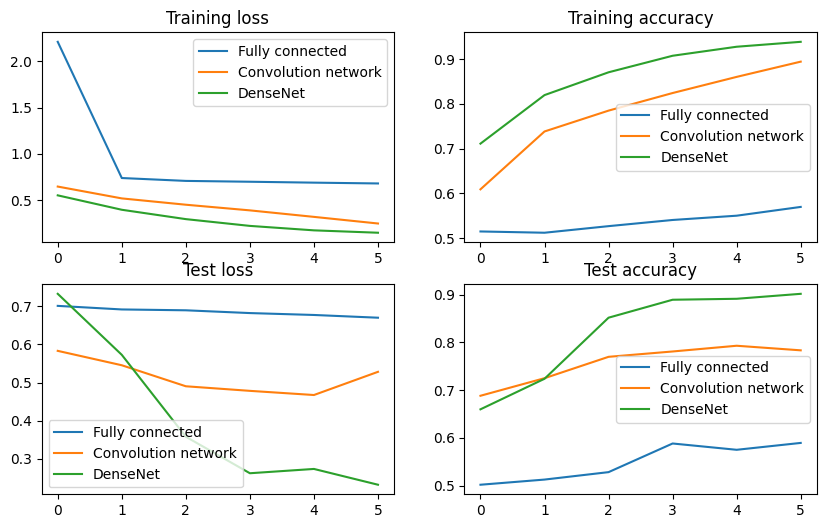

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.plot(fc_train_losses)
plt.plot(conv_train_losses)
plt.plot(dense_train_losses)
plt.legend(['Fully connected', 'Convolution network', 'DenseNet'])
plt.title('Training loss')

plt.subplot(2, 2, 2)
plt.plot((fc_train_accuracies))
plt.plot(conv_train_accuracies)
plt.plot(dense_train_accuracies)
plt.legend(['Fully connected', 'Convolution network', 'DenseNet'])
plt.title('Training accuracy')

plt.subplot(2, 2, 3)
plt.plot(fc_test_losses)
plt.plot(conv_test_losses)
plt.plot(dense_test_losses)
plt.legend(['Fully connected', 'Convolution network', 'DenseNet'])
plt.title('Test loss')

plt.subplot(2, 2, 4)
plt.plot((fc_test_accuracies))
plt.plot(conv_test_accuracies)
plt.plot(dense_test_accuracies)
plt.legend(['Fully connected', 'Convolution network', 'DenseNet'])
plt.title('Test accuracy')


***

## Reflection

Answer briefly following questions (in English or Finnish):
- Which model is best? Why?
- Is there some topics that should have been checked? E.g. training with more epochs?


*Your answers here...*

1) Analyysin perusteella DenseNet näyttää olevan paras malli. Tämä johtuu seuraavista tekijöistä:

Alhaisin harjoitus- ja testitappio

DenseNetin tappio (loss) on jatkuvasti alhaisin sekä harjoitus- että testivaiheessa verrattuna muihin malleihin. Alhaisempi tappio tarkoittaa, että mallin ennusteet ovat lähempänä todellisia arvoja. CN osuu DenseNetin ja FC:n väliin. FC näyttää kärsivän korkeasta tappiosta, mikä viittaa siihen, että se ei pysty minimoimaan virheitä tehokkaasti.

Korkein harjoitus- ja testitarkkuus

DenseNet saavuttaa kaikista malleista korkeimman harjoitus- ja testitarkkuuden, mikä tarkoittaa, että se tekee tarkimpia ennusteita. FC suoriutuu huonoimmin, kun taas konvoluutioneuroverkko parantaa suorituskykyä, mutta ei saavuta DenseNetin tasoa.

Parempi yleistyskyky

DenseNetin alhainen tappio ja korkea tarkkuus sekä harjoitus- että testidatassa viittaavat siihen, että se ei kärsi merkittävästä ylisovittamisesta (overfitting).FC näyttää puolestaan yleistyvän heikommin, sillä sen tarkkuus pysyy alhaisena. Näiden mittareiden perusteella DenseNet on tehokkain ja tarkin malli, sillä se minimoi virheet ja saavuttaa parhaan ennustustuloksen.

2) Tehtävät sisälsivät vain viisi harjoituskierrosta (epochia), mikä on todennäköisesti liian vähän kaikkien mallien täyden potentiaalin saavuttamiseksi. Pidempi harjoittelu voisi parantaa täysin yhdistetyn ja konvoluutioneuroverkon suorituskykyä. Kuitenkin DenseNet suoriutuu jo nyt parhaiten, joten se olisi todennäköisesti silti paras vaihtoehto pidemmällä harjoittelulla.

Vaikka DenseNet saavuttaa korkeimman tarkkuuden, on varmistettava, ettei se ylisovita harjoitusdataan.
Jos harjoitustarkkuus nousee huomattavasti korkeammaksi kuin testitarkkuus, malli saattaa muistaa harjoitusdatan yksityiskohtia oppimatta yleistettäviä piirteitä. Yksi tapa tarkistaa tämä on verrata harjoitus- ja testitappiota: jos testitappio alkaa kasvaa samalla kun harjoitustappio pienenee, ylisovittamista tapahtuu.

Oppimisnopeuden, eräkoon (batch size) ja optimointialgoritmin säätäminen voisi parantaa kaikkien mallien suorituskykyä. DenseNetin paremmuus voi johtua myös siitä, että sen valmiit painotukset hyperparametrit on valittu paremmin kyseiseen tehtävään.

### Great work!